In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Pre-processing of the data

### 1.2.1 Pre-processing of the sub-cateogry values

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in tqdm(catogories):
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)




100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 127224.55it/s]


In [6]:
from collections import Counter
my_counter = Counter()
for word in tqdm(project_data['clean_categories'].values):
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 201731.92it/s]


### 1.2.2 preprocessing of `project_subject_subcategories`

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.2.3 Text preprocessing

In [8]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [9]:
# project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [10]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [11]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in project_data['essay'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

In [14]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [15]:
project_data['essay'] = preprocessed_essays

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [16]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in project_data['project_title'].values:
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

In [17]:
preprocessed_titles[20000]

'need move input'

In [18]:
project_data['project_title'] = preprocessed_titles

### 1.4.1 Preprocessing of the teacher_prefix

In [19]:
project_data['teacher_prefix'].fillna("Others",inplace = True)
set(project_data['teacher_prefix'].values)

{'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Others', 'Teacher'}

### 1.4.2 Preprocessing of the price

In [20]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

###  1.4.3 Preprocessing of the Project_grad

In [21]:
lst = list(project_data['project_grade_category'].values)
preprocessed_grades = []
for l in lst:
    l = l.replace(' ','_')
    preprocessed_grades.append(l)
set(preprocessed_grades)

{'Grades_3-5', 'Grades_6-8', 'Grades_9-12', 'Grades_PreK-2'}

In [22]:
project_data['project_grade_category'] = preprocessed_grades

## 1.5 Preparing data for models

In [23]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

<h1>2. Logistic Regression </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [24]:
y = project_data["project_is_approved"]
X = project_data.drop("project_is_approved",axis = 1)
X.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [26]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
75103      170445  p215546  47e65e2e7f7576a30cae66937670f9b8        Teacher   
5755        79010  p188728  6531a54eb3faeb0fc364aaf9a49ed388           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
75103           CA        2016-08-10 01:50:47             Grades_3-5   
5755            SC        2016-09-30 14:25:23             Grades_3-5   

             project_title                                    project_essay_1  \
75103  high fives supplies  My third grade students are eager and excited ...   
5755               steppin  I am one of two PE teachers at a Title 1 schoo...   

                                project_resource_summary  \
75103  My students need books! I am implementing the ...   
5755   My students need FitBit Zips to help them unde...   

       teacher_number_of_previously_posted_projects   clean_categories  \
75103                                             1  Literacy_Language   
5755                                              4      Health_Sports   

               clean_subcategories  \
75103           Literature_Writing   
5755   Gym_Fitness Health_Wellness   

                                                   essay   price  quantity  
75103  third grade students eager excited learn many ...  709.35         8  
5755   one two pe teachers title 1 school located flo...  239.80        12

In [27]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [28]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000,ngram_range=(1,3))
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_ohe = vectorizer.transform(X_test['school_state'].values)

print("After One Hot encoding")
print(X_train_school_ohe.shape, y_train.shape)
print(X_cv_school_ohe.shape, y_cv.shape)
print(X_test_school_ohe.shape, y_test.shape)
print("="*100)
school_state_features = vectorizer.get_feature_names()

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)
After One Hot encoding
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)


In [29]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000,ngram_range=(1,3))
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After One Hot encoding")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print("="*100)
clean_categories_features = vectorizer.get_feature_names()

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)
After One Hot encoding
(49041, 47) (49041,)
(24155, 47) (24155,)
(36052, 47) (36052,)


In [30]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000,ngram_range=(1,3))
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After One Hot encoding")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print("="*100)
clean_subcategories_features = vectorizer.get_feature_names()

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)
After One Hot encoding
(49041, 210) (49041,)
(24155, 210) (24155,)
(36052, 210) (36052,)


In [31]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer = CountVectorizer(min_df=10, max_features=5000,ngram_range=(1,3))
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After One Hot encoding")
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print("="*100)
project_grade_category_features = vectorizer.get_feature_names()
print(set(X_train['project_grade_category'].values))

(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)
After One Hot encoding
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
{'Grades_3-5', 'Grades_PreK-2', 'Grades_6-8', 'Grades_9-12'}


In [32]:
# we use count vectorizer to convert the values into one 
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10, max_features=5000,ngram_range=(1,3))
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After One Hot encoding")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print("="*100)
teacher_prefix_category_features = vectorizer.get_feature_names()


(49041, 16) (49041,)
(24155, 16) (24155,)
(36052, 16) (36052,)
After One Hot encoding
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)


### 1.5.4 Numerical Variables

In [33]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

In [34]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [35]:
normalizer = Normalizer()
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_tnopp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_tnopp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_tnopp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_tnopp_norm.shape, y_train.shape)
print(X_cv_tnopp_norm.shape, y_cv.shape)
print(X_test_tnopp_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


### Vectorizing Text data

### BOW Vectorizations

In [36]:
vectorizer = CountVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
essay_bow_features = vectorizer.get_feature_names()


After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [37]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_cv_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)
title_bow_features = vectorizer.get_feature_names()

After vectorizations
(49041, 1983) (49041,)
(24155, 1983) (24155,)
(36052, 1983) (36052,)


###  TF-IDF Vectorizations

In [38]:
vectorizer = TfidfVectorizer(min_df=10, max_features=5000 )
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_idf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_idf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_idf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_idf.shape, y_train.shape)
print(X_cv_essay_idf.shape, y_cv.shape)
print(X_test_essay_idf.shape, y_test.shape)
print("="*100)
essay_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


In [39]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_idf = vectorizer.transform(X_train['project_title'].values)
X_cv_title_idf = vectorizer.transform(X_cv['project_title'].values)
X_test_title_idf = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_idf.shape, y_train.shape)
print(X_cv_title_idf.shape, y_cv.shape)
print(X_test_title_idf.shape, y_test.shape)
print("="*100)
title_tfidf_features = vectorizer.get_feature_names()

After vectorizations
(49041, 1983) (49041,)
(24155, 1983) (24155,)
(36052, 1983) (36052,)


### 1.5.2 AVG-W2V 

In [98]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [99]:
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)



100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [00:24<00:00, 1997.73it/s]


In [100]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:12<00:00, 1867.79it/s]


In [101]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:18<00:00, 1948.49it/s]


### For title

In [102]:
w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list  
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_train.append(vector)

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:01<00:00, 39912.52it/s]


In [103]:
w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list 
for sentence in tqdm(X_cv['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_cv.append(vector)

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 35774.85it/s]


In [104]:
w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    w2v_title_test.append(vector)

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 46463.33it/s]


### 1.5.2 TF-IDF weighted W2V

In [105]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49041/49041 [03:25<00:00, 238.34it/s]


49041
300


In [106]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_cv['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:40<00:00, 240.36it/s]


24155
300


In [107]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:48<00:00, 331.29it/s]


36052
300


### For title

In [108]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:01<00:00, 29443.85it/s]


49041
300


In [109]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_cv['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 28493.65it/s]


24155
300


In [110]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 29317.35it/s]


36052
300


<h1>2. Decision Tree </h1>

### 2.4.1 Set 1 BOW

In [40]:
print(X_train_essay_bow.shape)
print(X_train_title_bow.shape)
print(X_train_school_ohe.shape)
print(X_train_clean_categories_ohe.shape)
print(X_train_clean_subcategories_ohe.shape)
print(X_train_project_grade_category_ohe.shape)
print(X_train_teacher_prefix_ohe.shape)
print(X_train_price_norm.shape)
print(X_train_tnopp_norm.shape)


(49041, 5000)
(49041, 1983)
(49041, 51)
(49041, 47)
(49041, 210)
(49041, 6)
(49041, 4)
(1, 49041)
(1, 49041)


In [41]:
X_train_price_norm = X_train_price_norm.T
X_train_tnopp_norm = X_train_tnopp_norm.T
X_test_price_norm = X_test_price_norm.T
X_test_tnopp_norm = X_test_tnopp_norm.T
X_cv_price_norm = X_cv_price_norm.T
X_cv_tnopp_norm = X_cv_tnopp_norm.T


In [42]:
from scipy.sparse import hstack

# X_train_essay_bow X_train_title_bow X_train_school_ohe ,X_train_clean_categories_ohe X_train_clean_subcategories_ohe 
# X_train_project_grade_category_ohe,X_train_teacher_prefix_ohe,X_train_price_norm,X_train_tnopp_norm

X_tr = hstack((X_train_essay_bow, X_train_title_bow,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7303) (49041,)
(24155, 7303) (24155,)
(36052, 7303) (36052,)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


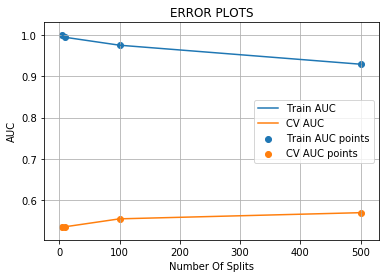

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

min_splits = [5, 10, 100, 500]
train_auc = []
cv_auc = []

for split in tqdm(min_splits):
    dt = DecisionTreeClassifier(min_samples_split = split)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for i in tqdm(range(0,4)):
    continue
plt.plot(min_splits, train_auc, label='Train AUC')
plt.plot(min_splits, cv_auc, label='CV AUC')

plt.scatter(min_splits, train_auc, label='Train AUC points')
plt.scatter(min_splits, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Number Of Splits")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




In [43]:
best_split = 500


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:59<00:00, 41.70s/it]

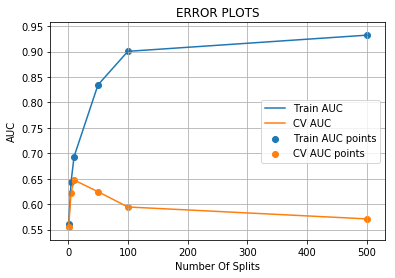

In [69]:
max_depth  =  [1, 5, 10, 50, 100, 500]
train_auc = []
cv_auc = []

for depth in tqdm(max_depth):
    dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = depth)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    

plt.plot(max_depth, train_auc, label='Train AUC')
plt.plot(max_depth, cv_auc, label='CV AUC')

plt.scatter(max_depth, train_auc, label='Train AUC points')
plt.scatter(max_depth, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("DEPTH")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [44]:
best_depth = 10

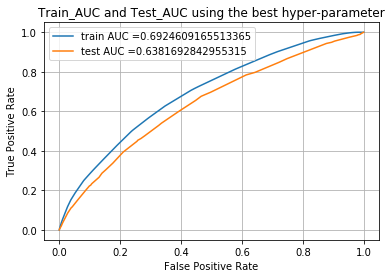

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc


dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = best_depth)
dt.fit(X_tr, y_train)

y_train_pred = dt.predict_proba(X_tr)[:,1]    
y_test_pred = dt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

In [46]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4090277351942263 for threshold 0.862


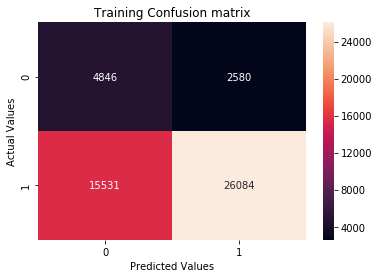

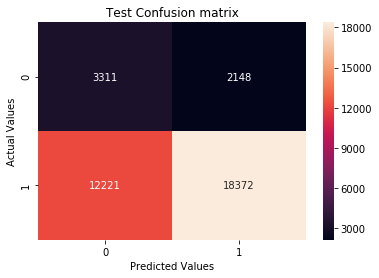

In [47]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [47]:
results = [['BOW',best_split,best_depth,auc(train_fpr, train_tpr)]]
results

[['BOW', 500, 10, 0.6931564992462456]]

### Visualizing using graphiz

In [49]:
# How to plot using GRAPH-VIZ : https://pythonprogramminglanguage.com/decision-tree-visual-example/

features = essay_bow_features + title_bow_features + school_state_features+clean_categories_features+clean_subcategories_features + project_grade_category_features + teacher_prefix_category_features
features.append("price_datae")
features.append("Teacher_Previously_submitted_Project")
len(features)

import pydotplus
from sklearn import tree
import collections

clf = DecisionTreeClassifier(min_samples_split = best_split,max_depth = 3)
clf.fit(X_tr, y_train)

dot_data = tree.export_graphviz(clf,feature_names=features,out_file=None,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])


graph.write_png('bow-viz.png')

True


### Word Count

In [53]:
essays_test = X_test_essay_bow.todense()
print(essays_test.shape)
features = essay_bow_features
len(features) 

(36052, 5000)


5000

In [49]:
a,p = list(y_test), predict_with_best_t(y_test_pred, best_t) # a = actual; p = predicted
fp_indices = []
for i in range(0,len(a)):
    if(a[i] == 0 and p[i] == 1):
        fp_indices.append(i)
len(fp_indices)

1984

In [50]:
max(fp_indices)

36044

In [65]:
essay_df = pd.DataFrame(essays_test).iloc[fp_indices,:]
print(essay_df.shape)


(1984, 5000)


1984

In [79]:
essay_sum_indices = []
for i in range(0,len(essay_df)):
    if essay_df[i].sum() > 50:
        essay_sum_indices.append(i)
len(essay_sum_indices)

323

In [86]:
arr = np.array([1,2,3,4])
print(arr.argsort())
print((-arr).argsort()) # descending order

[0 1 2 3]
[3 2 1 0]


In [90]:
top_indices = (-np.array(essay_sum_indices)).argsort()
top_features = []
for f in top_indices:
    top_features.append(features[f])
print(len(top_indices),len(top_features))

323 323


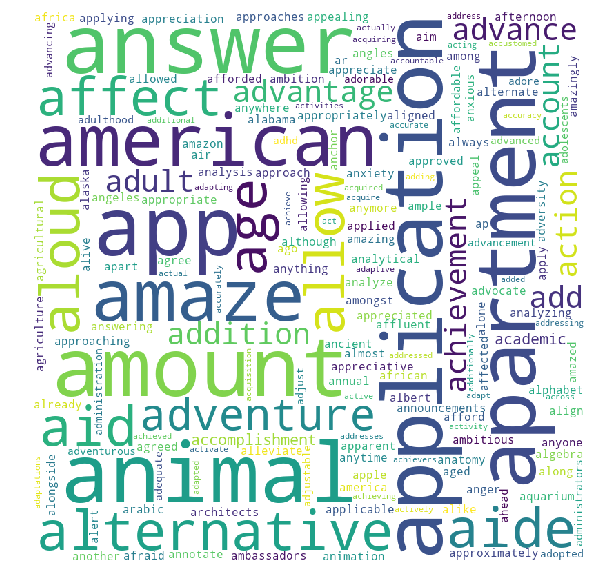

In [111]:
# Word Count : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

words = ""
for word in top_features:
    words = words +" "+ word
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Box plot with price

In [215]:
price_df = pd.DataFrame(X_test['price'])
price_df = price_df.iloc[fp_indices,:]
price_df.shape

(2658, 1)

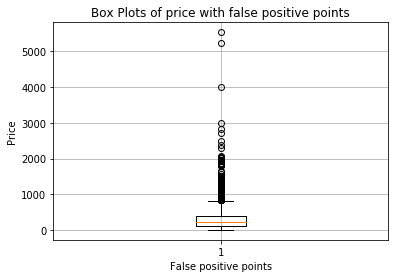

In [216]:
plt.boxplot(price_df.values)
plt.title('Box Plots of price with false positive points')
plt.xlabel('False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

### pdf with the teacher_number_of_previously_posted_projects of these false positive data points

In [221]:
tnoppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects']).iloc[fp_indices,:]
tnoppp_df.shape

(2658, 1)

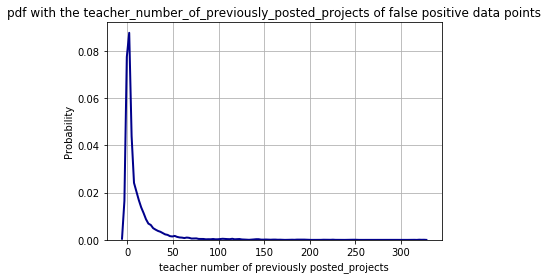

In [227]:
# Density Plot of data : https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

sns.distplot(tnoppp_df, hist=False, kde=True, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.title("pdf with the teacher_number_of_previously_posted_projects of false positive data points")
plt.xlabel("teacher number of previously posted_projects")
plt.ylabel("Probability")
plt.grid()
plt.show()

### 2.4.2 TF-IDF 

In [50]:
from scipy.sparse import hstack

X_tr = hstack((X_train_essay_idf, X_train_title_idf,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_idf, X_cv_title_idf,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_idf, X_test_title_idf,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7303) (49041,)
(24155, 7303) (24155,)
(36052, 7303) (36052,)



100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2005.40it/s]

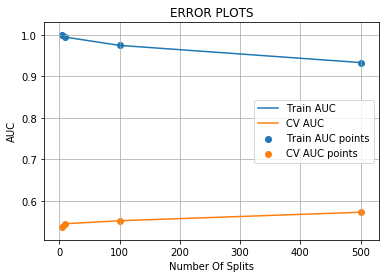

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

min_splits = [5, 10, 100, 500]
train_auc = []
cv_auc = []

for split in tqdm(min_splits):
    dt = DecisionTreeClassifier(min_samples_split = split)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(min_splits, train_auc, label='Train AUC')
plt.plot(min_splits, cv_auc, label='CV AUC')

plt.scatter(min_splits, train_auc, label='Train AUC points')
plt.scatter(min_splits, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Number Of Splits")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




In [51]:
best_split = 300


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:39<00:00, 50.23s/it]

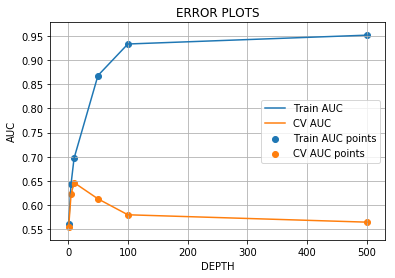

In [77]:
max_depth  =  [1, 5, 10, 50, 100, 500]
train_auc = []
cv_auc = []

for depth in tqdm(max_depth):
    dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = depth)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    

plt.plot(max_depth, train_auc, label='Train AUC')
plt.plot(max_depth, cv_auc, label='CV AUC')

plt.scatter(max_depth, train_auc, label='Train AUC points')
plt.scatter(max_depth, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("DEPTH")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [114]:
best_depth = 10

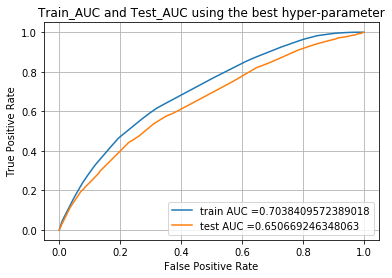

In [115]:
from sklearn.metrics import roc_curve, auc


dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = best_depth)
dt.fit(X_tr, y_train)

y_train_pred = dt.predict_proba(X_tr)[:,1]    
y_test_pred = dt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.4186178310606903 for threshold 0.853


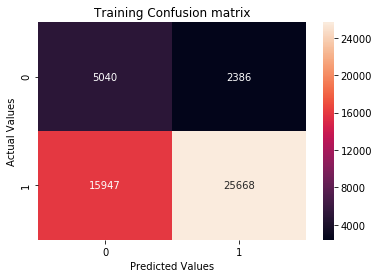

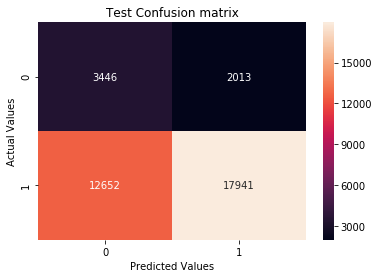

In [116]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [81]:
results_2 = [['TF-IDF',best_split,best_depth,auc(train_fpr, train_tpr)]]
results_2

[['TF-IDF', 300, 10, 0.6968073505679766]]

### Visualizing Tree

In [149]:
features = essay_tfidf_features + title_tfidf_features + school_state_features+clean_categories_features+clean_subcategories_features + project_grade_category_features + teacher_prefix_category_features
features.append("Price")
features.append("Teacher_Previously_submitted_Project")
len(features)

7296

In [52]:
# https://pythonprogramminglanguage.com/decision-tree-visual-example/

# How to plot using GRAPH-VIZ : https://pythonprogramminglanguage.com/decision-tree-visual-example/


import pydotplus
from sklearn import tree
import collections

clf = DecisionTreeClassifier(min_samples_split = best_split,max_depth = 3)
clf.fit(X_tr, y_train)

dot_data = tree.export_graphviz(clf,feature_names=features,out_file=None,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])


graph.write_png('tfidf-viz.png')

True


### Word Count

In [118]:
essays_test = X_test_essay_idf.todense()
print(essays_test.shape)
features = essay_tfidf_features
len(features) 

(36052, 5000)


5000

In [119]:
a,p = list(y_test), predict_with_best_t(y_test_pred, best_t) # a = actual; p = predicted
fp_indices = []
for i in range(0,len(a)):
    if(a[i] == 0 and p[i] == 1):
        fp_indices.append(i)
len(fp_indices)

2013

In [120]:
max(fp_indices)

35987

In [121]:
essay_df = pd.DataFrame(essays_test).iloc[fp_indices,:]
print(essay_df.shape)


(2013, 5000)


In [125]:
essay_sum_indices = []
for i in range(0,len(essay_df)):
    if essay_df[i].sum() > 5:
        essay_sum_indices.append(i)
len(essay_sum_indices)

303

In [126]:
arr = np.array([1,2,3,4])
print(arr.argsort())
print((-arr).argsort()) # descending order

[0 1 2 3]
[3 2 1 0]


In [127]:
top_indices = (-np.array(essay_sum_indices)).argsort()
top_features = []
for f in top_indices:
    top_features.append(features[f])
print(len(top_indices),len(top_features))

303 303


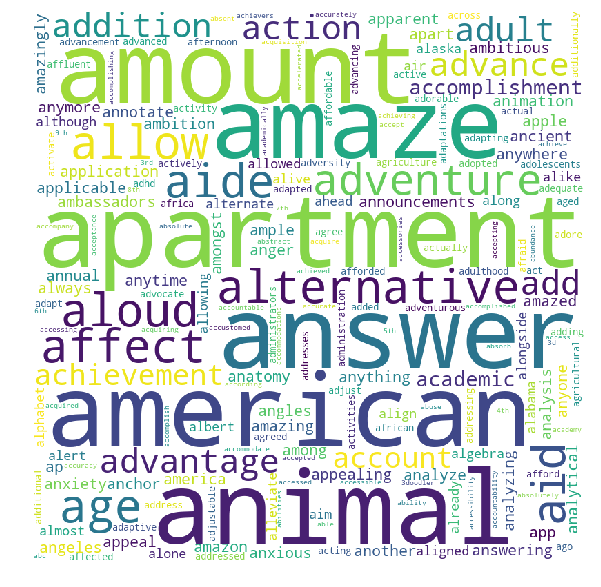

In [128]:
# Word Count : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

words = ""
for word in top_features:
    words = words +" "+ word
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Box plot with price

(1924, 1)


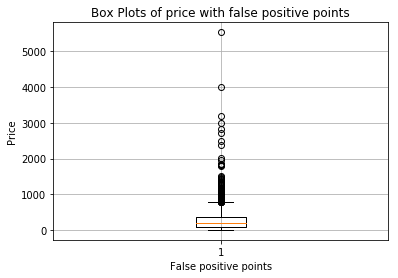

In [234]:
price_df = pd.DataFrame(X_test['price'])
price_df = price_df.iloc[fp_indices,:]
print(price_df.shape)

plt.boxplot(price_df.values)
plt.title('Box Plots of price with false positive points')
plt.xlabel('False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

### pdf with the teacher_number_of_previously_posted_projects of these false positive data points

(1924, 1)


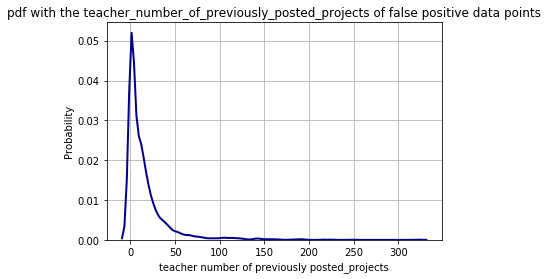

In [235]:
tnoppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects']).iloc[fp_indices,:]
print(tnoppp_df.shape)

# Density Plot of data : https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

sns.distplot(tnoppp_df, hist=False, kde=True, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.title("pdf with the teacher_number_of_previously_posted_projects of false positive data points")
plt.xlabel("teacher number of previously posted_projects")
plt.ylabel("Probability")
plt.grid()
plt.show()

# Set 5 : Selecting top 5000 features

In [129]:
X_tr = hstack((X_train_essay_idf, X_train_title_idf,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((X_cv_essay_idf, X_cv_title_idf,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((X_test_essay_idf, X_test_title_idf,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 7304) (49041,)
(24155, 7304) (24155,)
(36052, 7304) (36052,)


In [134]:
print(type(new_clf.feature_importances_))
len(new_clf.feature_importances_)

<class 'numpy.ndarray'>


7304

In [135]:
features = essay_tfidf_features + title_tfidf_features + school_state_features+clean_categories_features+clean_subcategories_features + project_grade_category_features + teacher_prefix_category_features
features.append("Price")
features.append("Teacher_Previously_submitted_Project")
len(features)

7304

In [136]:
all_features = new_clf.feature_importances_
arr2 = (-all_features).argsort()[:5000]
print(arr2)
len(arr2)

[7302 2819 7303 ...  136  135  134]


5000

In [137]:
X_tr = X_tr[:,arr2]
X_cr = X_cr[:,arr2]
X_te = X_te[:,arr2]

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:02<00:21,  2.34s/it]

 20%|████████████████▌                                                                  | 2/10 [00:02<00:14,  1.79s/it]

 30%|████████████████████████▉                                                          | 3/10 [00:03<00:10,  1.46s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:07,  1.30s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:07,  1.50s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:09,  2.37s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:21<00:14,  4.92s/it]

 80%|█████████████████████████

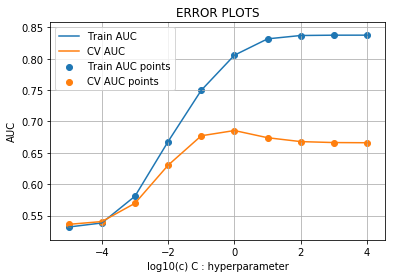

In [182]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

c_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
train_auc = []
cv_auc = []
log_c = []

for c in tqdm(c_values):
    lr = LogisticRegression(C = c)
    lr.fit(X_tr, y_train)
    
    y_train_pred = lr.predict_proba( X_tr)[:,1]    
    y_cv_pred = lr.predict_proba( X_cr)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
    log_c.append(math.log10(c))

plt.plot(log_c, train_auc, label='Train AUC')
plt.plot(log_c, cv_auc, label='CV AUC')

plt.scatter(log_c, train_auc, label='Train AUC points')
plt.scatter(log_c, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log10(c) C : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



In [138]:
best_c = 0.01

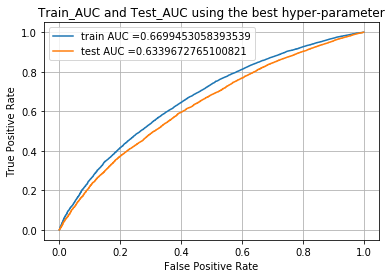

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc


lr = LogisticRegression(C = best_c)
lr.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = lr.predict_proba( X_tr)[:,1]    
y_test_pred = lr.predict_proba( X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.38768391685301956 for threshold 0.841


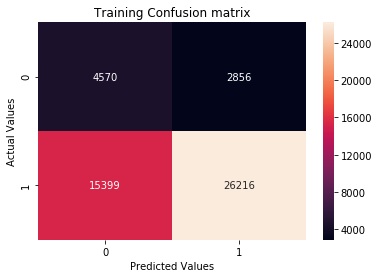

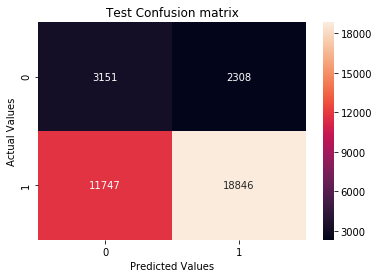

In [140]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [187]:
results_5 = [['Step-5',best_c,'NaN',auc(train_fpr, train_tpr)]]
results_5

[['Step-5', 0.01, 'NaN', 0.6680308176806624]]

### Word Count

In [141]:
essays_test = X_test_essay_idf.todense()
print(essays_test.shape)
features = essay_tfidf_features
len(features) 

(36052, 5000)


5000

In [142]:
a,p = list(y_test), predict_with_best_t(y_test_pred, best_t) # a = actual; p = predicted
fp_indices = []
for i in range(0,len(a)):
    if(a[i] == 0 and p[i] == 1):
        fp_indices.append(i)
len(fp_indices)

2308

In [143]:
max(fp_indices)

36048

In [144]:
essay_df = pd.DataFrame(essays_test).iloc[fp_indices,:]
print(essay_df.shape)


(2308, 5000)


In [146]:
essay_sum_indices = []
for i in range(0,len(essay_df)):
    if essay_df[i].sum() > 10:
        essay_sum_indices.append(i)
len(essay_sum_indices)

201

In [147]:
arr = np.array([1,2,3,4])
print(arr.argsort())
print((-arr).argsort()) # descending order

[0 1 2 3]
[3 2 1 0]


In [148]:
top_indices = (-np.array(essay_sum_indices)).argsort()
top_features = []
for f in top_indices:
    top_features.append(features[f])
print(len(top_indices),len(top_features))

201 201


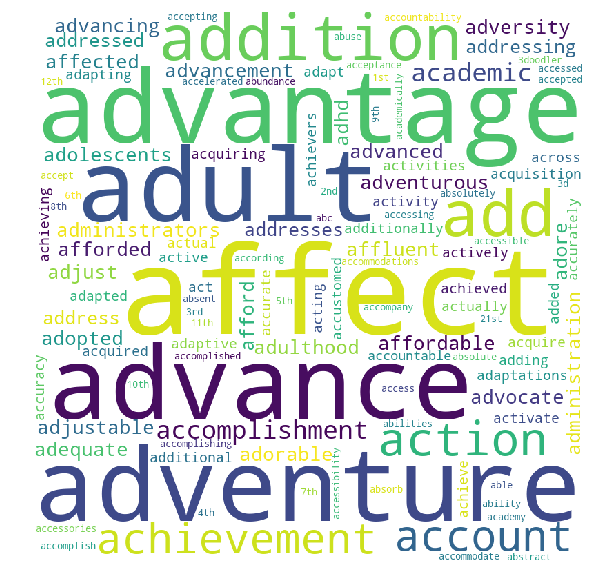

In [149]:
# Word Count : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

words = ""
for word in top_features:
    words = words +" "+ word
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Box plot with price

(2260, 1)


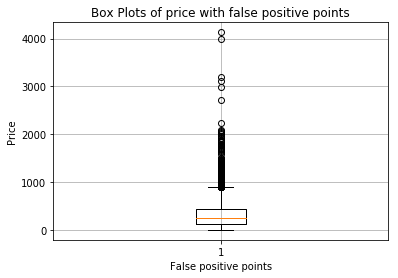

In [241]:
price_df = pd.DataFrame(X_test['price'])
price_df = price_df.iloc[fp_indices,:]
print(price_df.shape)

plt.boxplot(price_df.values)
plt.title('Box Plots of price with false positive points')
plt.xlabel('False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

### pdf with the teacher_number_of_previously_posted_projects of these false positive data points

(2260, 1)


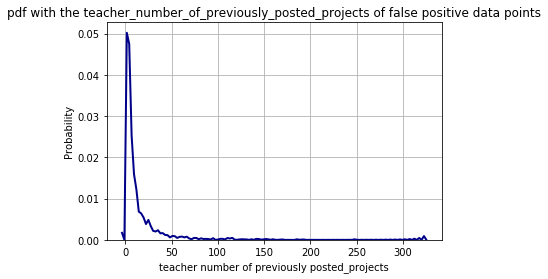

In [242]:
tnoppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects']).iloc[fp_indices,:]
print(tnoppp_df.shape)

# Density Plot of data : https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

sns.distplot(tnoppp_df, hist=False, kde=True, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.title("pdf with the teacher_number_of_previously_posted_projects of false positive data points")
plt.xlabel("teacher number of previously posted_projects")
plt.ylabel("Probability")
plt.grid()
plt.show()

### 2.4.3 Average Word-2-Vec

In [97]:
X_tr = hstack((avg_w2v_vectors_train, w2v_title_train,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, w2v_title_cv,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((avg_w2v_vectors_test, w2v_title_test,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 922) (49041,)
(24155, 922) (24155,)
(36052, 922) (36052,)



100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4010.81it/s]

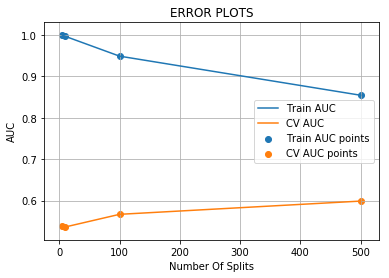

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

min_splits = [5, 10, 100, 500]
train_auc = []
cv_auc = []

for split in tqdm(min_splits):
    dt = DecisionTreeClassifier(min_samples_split = split)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    

plt.plot(min_splits, train_auc, label='Train AUC')
plt.plot(min_splits, cv_auc, label='CV AUC')

plt.scatter(min_splits, train_auc, label='Train AUC points')
plt.scatter(min_splits, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Number Of Splits")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




In [243]:
best_split = 350


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [16:40<00:00, 211.97s/it]

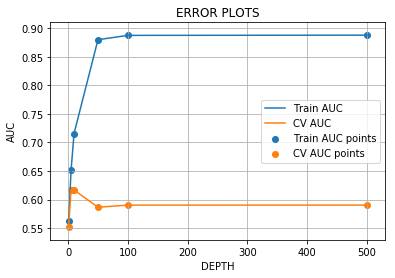

In [100]:
max_depth  =  [1, 5, 10, 50, 100, 500]
train_auc = []
cv_auc = []

for depth in tqdm(max_depth):
    dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = depth)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    

plt.plot(max_depth, train_auc, label='Train AUC')
plt.plot(max_depth, cv_auc, label='CV AUC')

plt.scatter(max_depth, train_auc, label='Train AUC points')
plt.scatter(max_depth, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("DEPTH")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [244]:
best_depth = 10

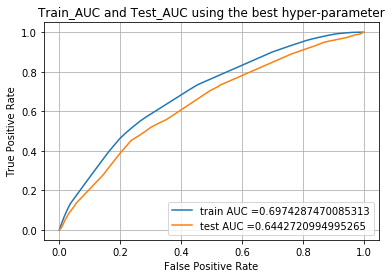

In [245]:
from sklearn.metrics import roc_curve, auc


dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = best_depth)
dt.fit(X_tr, y_train)

y_train_pred = dt.predict_proba(X_tr)[:,1]    
y_test_pred = dt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.4081279671791675 for threshold 0.857


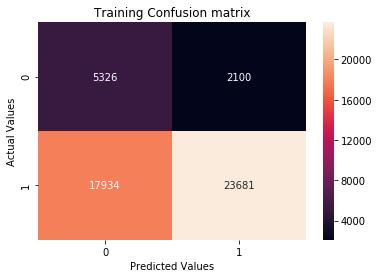

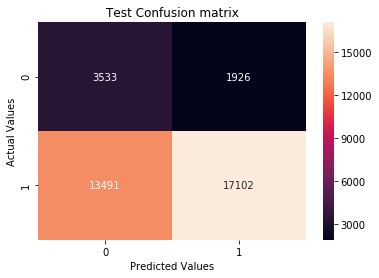

In [246]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [104]:
results_3 = [['Average Word-2-Vec',best_split,best_depth,auc(train_fpr, train_tpr)]]
results_3

[['Average Word-2-Vec', 350, 10, 0.7152902381069415]]

### Box plot with price

(1926, 1)


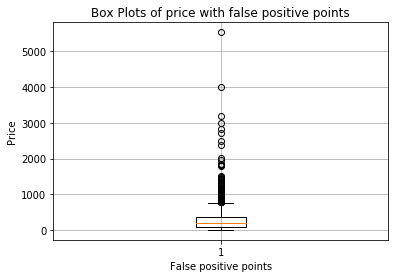

In [249]:
price_df = pd.DataFrame(X_test['price'])
price_df = price_df.iloc[fp_indices,:]
print(price_df.shape)

plt.boxplot(price_df.values)
plt.title('Box Plots of price with false positive points')
plt.xlabel('False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

### pdf with the teacher_number_of_previously_posted_projects of these false positive data points

(1926, 1)


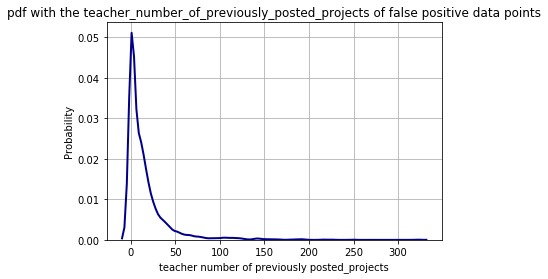

In [250]:
tnoppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects']).iloc[fp_indices,:]
print(tnoppp_df.shape)

# Density Plot of data : https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

sns.distplot(tnoppp_df, hist=False, kde=True, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.title("pdf with the teacher_number_of_previously_posted_projects of false positive data points")
plt.xlabel("teacher number of previously posted_projects")
plt.ylabel("Probability")
plt.grid()
plt.show()

### 2.4.4 TFIDF weighted Word-2-Vec

In [114]:
X_tr = hstack((tfidf_w2v_vectors_train, tfidf_w2v_title_train,X_train_school_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_project_grade_category_ohe , X_train_teacher_prefix_ohe, X_train_price_norm, X_train_tnopp_norm)).tocsr()
X_cr = hstack((tfidf_w2v_vectors_cv, tfidf_w2v_title_cv,X_cv_school_ohe, X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_project_grade_category_ohe , X_cv_teacher_prefix_ohe, X_cv_price_norm, X_cv_tnopp_norm)).tocsr()
X_te = hstack((tfidf_w2v_vectors_test, tfidf_w2v_title_test,X_test_school_ohe, X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_project_grade_category_ohe , X_test_teacher_prefix_ohe, X_test_price_norm, X_test_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 922) (49041,)
(24155, 922) (24155,)
(36052, 922) (36052,)




  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 25%|████████████████████▊                                                              | 1/4 [05:17<15:51, 317.04s/it]

 50%|█████████████████████████████████████████▌                                         | 2/4 [10:23<10:27, 313.72s/it]

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [15:15<05:07, 307.23s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [18:19<00:00, 270.27s/it]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4013.69it/s]

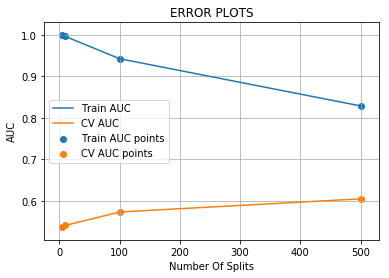

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math

min_splits = [5, 10, 100, 500]
train_auc = []
cv_auc = []

for split in tqdm(min_splits):
    dt = DecisionTreeClassifier(min_samples_split = split)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for i in tqdm(range(0,4)):
    continue
plt.plot(min_splits, train_auc, label='Train AUC')
plt.plot(min_splits, cv_auc, label='CV AUC')

plt.scatter(min_splits, train_auc, label='Train AUC points')
plt.scatter(min_splits, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Number Of Splits")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()




In [251]:
best_split = 350



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:05<00:26,  5.27s/it]

 33%|████████████████████████████                                                        | 2/6 [00:29<00:43, 10.90s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:31<01:18, 26.24s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [05:27<02:58, 89.25s/it]

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [10:04<02:25, 145.62s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [14:44<00:00, 185.96s/it]

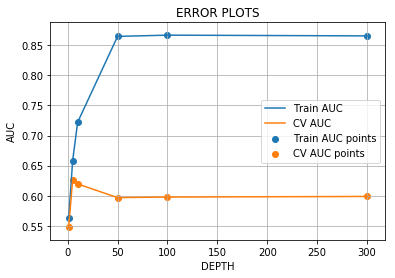

In [117]:
max_depth  =  [1, 5, 10, 50, 100, 300]
train_auc = []
cv_auc = []

for depth in tqdm(max_depth):
    dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = depth)
    dt.fit(X_tr, y_train)
    
    y_train_pred = dt.predict_proba(X_tr)[:,1]    
    y_cv_pred = dt.predict_proba(X_cr)[:,1]  
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    

plt.plot(max_depth, train_auc, label='Train AUC')
plt.plot(max_depth, cv_auc, label='CV AUC')

plt.scatter(max_depth, train_auc, label='Train AUC points')
plt.scatter(max_depth, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("DEPTH")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [252]:
best_depth = 5

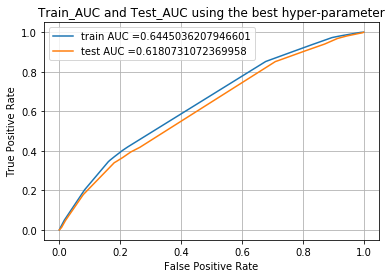

In [253]:
from sklearn.metrics import roc_curve, auc


dt = DecisionTreeClassifier(min_samples_split = best_split,max_depth = best_depth)
dt.fit(X_tr, y_train)

y_train_pred = dt.predict_proba(X_tr)[:,1]    
y_test_pred = dt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train_AUC and Test_AUC using the best hyper-parameter")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.3253202190484582 for threshold 0.853


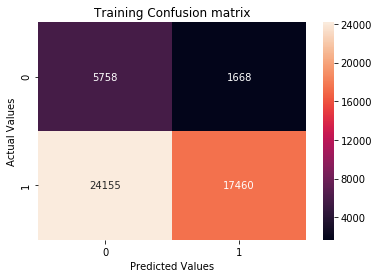

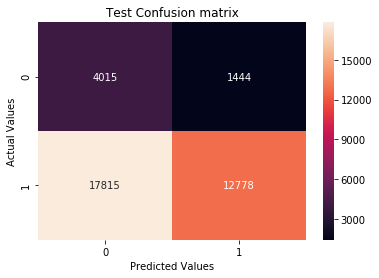

In [254]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
df_cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Training Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

df_cm = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
ax = sns.heatmap(df_cm,annot=True, fmt="d")
plt.title("Test Confusion matrix")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [121]:
results_4 = [['TFIDF Word-2Vec',best_split,best_depth,auc(train_fpr, train_tpr)]]
results_4

[['TFIDF Word-2Vec', 350, 5, 0.6583503900344101]]

### Box plot with price

(1444, 1)


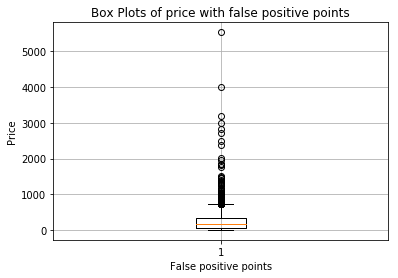

In [257]:
price_df = pd.DataFrame(X_test['price'])
price_df = price_df.iloc[fp_indices,:]
print(price_df.shape)

plt.boxplot(price_df.values)
plt.title('Box Plots of price with false positive points')
plt.xlabel('False positive points')
plt.ylabel('Price')
plt.grid()
plt.show()

### pdf with the teacher_number_of_previously_posted_projects of these false positive data points

(1444, 1)


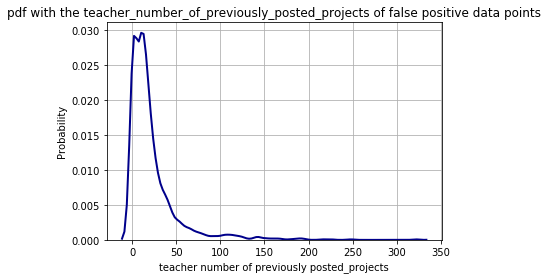

In [258]:
tnoppp_df = pd.DataFrame(X_test['teacher_number_of_previously_posted_projects']).iloc[fp_indices,:]
print(tnoppp_df.shape)

# Density Plot of data : https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

sns.distplot(tnoppp_df, hist=False, kde=True, color = 'darkblue',hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
plt.title("pdf with the teacher_number_of_previously_posted_projects of false positive data points")
plt.xlabel("teacher number of previously posted_projects")
plt.ylabel("Probability")
plt.grid()
plt.show()

# Final Conclusion

In [188]:
from tabulate import tabulate

final_results = results.copy()
final_results.append(results_2[0])
final_results.append(results_3[0])
final_results.append(results_4[0])
final_results.append(results_5[0])
final_results

print(tabulate(final_results, headers=['Vectorizer','Best Split','Best Depth','AUC'],tablefmt='orgtbl'))

| Vectorizer         |   Best Split |   Best Depth |      AUC |
|--------------------+--------------+--------------+----------|
| BOW                |       500    |           10 | 0.693537 |
| TF-IDF             |       300    |           10 | 0.696807 |
| Average Word-2-Vec |       350    |           10 | 0.71529  |
| TFIDF Word-2Vec    |       350    |            5 | 0.65835  |
| Step-5             |         0.01 |          nan | 0.668031 |
